## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#con)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
# 294478 observations in this dataset
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
df.query('converted == 1')['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
# The row is in new page but is not in treatment group.
# OR the row is not in new page but is in treatment group.
df.query('landing_page == "new_page" & group != "treatment"').count()[0] + df.query('landing_page != "new_page" & group == "treatment"').count()[0]


3893

f. Do any of the rows have missing values?

In [7]:
# There is no missing values in this dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('landing_page == "new_page" & group == "treatment" | landing_page == "old_page" & group == "control"')


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# user_id = 773192
df2["is_duplicate"]= df2['user_id'].duplicated()
df2.query('is_duplicate == True')

/Users/jemchang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,is_duplicate
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted,is_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Keep the first record and delete the second one
df2 = df2.drop_duplicates(subset='user_id', keep="first")

In [14]:
# check duplicates
sum(df2['is_duplicate'])

0

In [15]:
# check the duplicate user_id
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted,is_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False


`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
sum(df2.query('converted == 1').converted)/len(df2['user_id'])

0.11959708724499628

In [17]:
# save convert rate in this dataset as con_obs
con_obs = df2['converted'].mean()
con_obs

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# calculate and save convert rate in the control group in this dataset as con_c
con_c = len(df2.query('converted == 1 & group == "control"')['user_id'])/len(df2.query('group == "control"')['user_id'])
con_c

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# calculate and save convert rate in the treatment group in this dataset as con_t
con_t = len(df2.query('converted == 1 & group == "treatment"')['user_id'])/len(df2.query('group == "treatment"')['user_id'])
con_t

0.11880806551510564

In [20]:
# The difference of convert rates between the control group and treatment group
obs_diffs = con_t - con_c
obs_diffs

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [21]:
len(df2.query('landing_page == "new_page"')['user_id'])/len(df2['user_id'])

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

> This dataset includes two groups, old page (control) and new page (treatment), equally. The convert rate in this dataset is 11.96% regardless of pages. The convert rate in the old page is 12.04% than the convert rate in the new page, 11.88%. The differeence is only 0.15%, so it is very hard to tell which page leads to more conversions than another. We need to implement an experiment to see if the difference is statistically significant. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0: **$p_{old}$** >= **$p_{new}$**   
Ha: **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
pnew=con_obs
pnew

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
pold=con_obs
pold

0.11959708724499628

c. What is $n_{new}$?

In [19]:
df2['group'].value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

In [27]:
nnew = len(df2.query('group == "treatment"')['group'])
nnew

145310

> $n_{new}$ = 145310

d. What is $n_{old}$?

In [28]:
nold = len(df2.query('group == "control"')['group'])
nold

145274

>$n_{old}$ = 145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.binomial(1, pnew, nnew)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.binomial(1, pold, nold)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
new_page_converted.mean() - old_page_converted.mean()

0.0002043636209243388

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [32]:
p_diffs = []

for _ in range(10000):
    new_page_conv = np.random.binomial(1, pnew, nnew).mean()
    old_page_conv = np.random.binomial(1, pold, nold).mean()
    p_diffs.append(new_page_conv - old_page_conv)

In [33]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?

> It looks like bell-shaped normal distribution

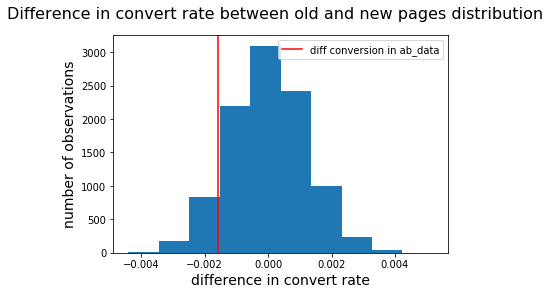

In [98]:
fig = plt.figure()
plt.hist(p_diffs)
plt.axvline(obs_diffs, c='red', label='diff conversion in ab_data')
plt.legend()
fig.suptitle('Difference in convert rate between old and new pages distribution', fontsize=16)
plt.xlabel('difference in convert rate', fontsize=14)
plt.ylabel('number of observations', fontsize=14);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
(p_diffs > obs_diffs).mean() # pnew - pold

0.9061

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> From j, the value, 0.9061, called p-value. At a Type I error rate of 5%, we cannot reject the null hypothesis that is the old page better than the new page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [49]:
import statsmodels.api as sm

convert_old = len(df2.query('converted == 1 & group == "control"')['user_id'])
convert_new = len(df2.query('converted == 1 & group == "treatment"')['user_id'])
n_old = nold
n_new = nnew
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [51]:
zscore, pvalue = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller', prop_var = False)

In [54]:
zscore, pvalue

(1.3109241984234394, 0.9050583127590245)

In [56]:
from scipy.stats import norm
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> The z-score does not exceed 1.645 and the p-value, 0.905, is larger than the Type I error rate of 5%, so we cannot reject the null hypothesis. The p-value from j and k, 0.9061 gives us the same conclusion from this experiment. That is, the old page is better than the new page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
# 1. add intercept
df2['intercept'] = 1

In [41]:
# 2. add a dummy variable for control and treatment groups
ab_page = pd.get_dummies(df2['group'])
df2 = df2.join(ab_page)
df2.head()

,user_id,timestamp,group,landing_page,converted,is_duplicate,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0


In [42]:
df2 = df2.rename(columns={'treatment': 'ab_page'})

In [43]:
df2.head()

,user_id,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [63]:
model = sm.Logit(df2['converted'],df2[['intercept','ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [64]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 19 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        12:18:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br> 

> For the hypothesis test in logistic regression, we calculate odds ratio (log(p/1-p)) and test that there is any relationship between convert rates and pages of groups. Here, p-value is 0.19 which means there is no relationship between convert rates and pages of groups at a Type I error of 5%. For the hypothesis tests in ab test and two sample proportion, we calculate the proportions in two groups and test that there is any difference of convert rates between new pages and old pages. Here, p-value is 0.9 means that we cannot reject the null hypothesis, the convert rate in the old page is better than in the new page at a Type I error of 5%. Because of different calculations, our p-values are different but we get the same conclusion.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> After implemeting the logistic regression, we cannot prove that new page has the better convert rate from the current dataset, so it is a good idea to find if there are other factors that influence the convert rate.  

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion? 

In [44]:
dfcountries = pd.read_csv('countries.csv')
dfcountries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [55]:
df3 = df2.join(dfcountries.set_index('user_id'), on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0,US


In [73]:
df3['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [57]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0,US,0,0,1


In [81]:
model2 = sm.Logit(df3['converted'],df3[['intercept','ab_page','UK','CA']]).fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [82]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 19 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        13:24:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

> After adding the country variable, p-values in UK and CA are 0.457 and 0.13 respectively, which are larger than type I error, 0.05,  which means country does not have an significant impact on convert rate.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [58]:
df3['page_CA'] = df3['ab_page'] * df3['CA']
df3['page_UK'] = df3['ab_page'] * df3['UK']
df3.head()

,user_id,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page,country,CA,UK,US,page_CA,page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0,US,0,0,1,0,0


In [85]:
model3 = sm.Logit(df3['converted'],df3[['intercept','ab_page','UK','CA','page_CA','page_UK']]).fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [86]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 19 Jan 2019   Pseudo R-squ.:               3.482e-05
Time:                        13:36:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
page_CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

> After adding the interaction variables between pages and countries, the p-values in page_CA and page_UK are 0.383 and 0.238 which are larger than type I error, 0.05. That is, the interaction terms do not have an significant impacts on convert rate.

i. Find if time associates with the convert rates. Here, I will convert timestamp from string to datetime and then categorize it into weekdays.

In [60]:
# Time
df3['timestamp'] = pd.to_datetime(df3['timestamp'])
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 15 columns):
user_id         290584 non-null int64
timestamp       290584 non-null datetime64[ns]
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
is_duplicate    290584 non-null bool
intercept       290584 non-null int64
control         290584 non-null uint8
ab_page         290584 non-null uint8
country         290584 non-null object
CA              290584 non-null uint8
UK              290584 non-null uint8
US              290584 non-null uint8
page_CA         290584 non-null uint8
page_UK         290584 non-null uint8
dtypes: bool(1), datetime64[ns](1), int64(3), object(3), uint8(7)
memory usage: 20.0+ MB


In [61]:
df3['Day of Week'] = df3['timestamp'].apply(lambda time: time.dayofweek)

In [51]:
df3['Day of Week'].value_counts()

1    47148
0    45440
6    39915
5    39669
4    39626
2    39565
3    39221
Name: Day of Week, dtype: int64

In [62]:
dayofweek = pd.get_dummies(df3['Day of Week'])
df3 = df3.join(dayofweek)
df.head()

,user_id,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page,country,...,page_CA,page_UK,Day of Week,0,1,2,3,4,5,6
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0,US,...,0,0,5,0,0,0,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0,US,...,0,0,3,0,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1,US,...,0,0,2,0,0,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1,US,...,0,0,6,0,0,0,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0,US,...,0,0,5,0,0,0,0,0,1,0


In [63]:
df3 = df3.rename(columns={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
df3.head()

,user_id,timestamp,group,landing_page,converted,is_duplicate,intercept,control,ab_page,country,...,page_CA,page_UK,Day of Week,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,False,1,1,0,US,...,0,0,5,0,0,0,0,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,False,1,1,0,US,...,0,0,3,0,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1,US,...,0,0,2,0,0,1,0,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1,US,...,0,0,6,0,0,0,0,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,False,1,1,0,US,...,0,0,5,0,0,0,0,0,1,0


In [68]:
model4 = sm.Logit(df3['converted'],df3[['intercept','ab_page', 'Tue','Wed','Thu','Fri','Sat','Sun']]).fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [69]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            7
Date:                Sun, 20 Jan 2019   Pseudo R-squ.:               3.402e-05
Time:                        19:29:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4044
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9742      0.015   -127.752      0.000      -2.004      -1.944
ab_page       -0.0149      0.011     -1.306      0.192      -0.037       0.007
Tue           -0.0152      0.020     -0.752      0.452      -0.055       0.024
Wed           -0.0076      0.021     -0.362      0.717      -0.049       0.034
Thu           -0.0111      0.021     -0.526      0.599      -0.053       0.030
Fri           -0.0425      0.021     -1.999      0.046      -0.084      -0.001
Sat           -0.0030      0.021     -0.145      0.885      -0.044       0.038
Sun           -0.0253      0.021     -1.199      0.231      -0.067       0.016
==============================================================================
"""

> After building another logistic regression for groups of pages and weekdays, we can see that the p-value of Friday is 0.046 smaller than the Type I error of 5%, which means Friday has an significant impact on the convert rates.   

<a id='con'></a>
### Conclusion  
After performing the ab test, I conclude that the difference in the convert rates between the old page and the new page is very small and the p-value cannot reject the null hypothesis, the convert rate in the old page is better than in the new page. The result from the logistic regression also indicates that there is no statistically significant between the convert rate and groups of page. I add the country variable but the conclusion still remains the same. However, after categorizing the timestamp variable as weekdays and adding it to the model, the result shows that Friday has a significant impact on the convert rate. For the next step, we can investigate more on time, add other features and run the experiment longer to see if we can get more insights.